In [1]:
# Code to train MSGAN model
# Adapted from the original DeOldify repository https://github.com/jantic/DeOldify/blob/master/ColorizeTrainingStable.ipynb

In [2]:
from deoldify import device
from deoldify.device_id import DeviceId
device.set(device=DeviceId.GPU0)

<DeviceId.GPU0: 0>

In [3]:
import os
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from fastai.vision.image import *
from fastai.vision.transform import _crop_pad
from fastai.torch_core import *
from deoldify.generators import *
from deoldify.critics import *
from deoldify.dataset import *
from deoldify.loss import *
from deoldify.save import *
from deoldify.gan import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm
import wandb
from wandbCall import WandbCallback

from PIL import Image as pimg
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np

from deoldify.unet import *
from fastai.vision.learner import cnn_config
from deoldify.gan import *

fastai.__version__ # should be 1.0.52

'1.0.52'

In [4]:
# sets the root directory
path = Path('/mnt/Data/ILSVRC/Data/CLS-LOC')
path_hr = path
path_lr = path/'bw'

# for training with paired images
# paired at different folder before training, to reduce runtime operations
# generate with create_training_images_pair() method
path_lr_pair = path/'bw_pair'
path_hr_pair = path/'col_pair'

# set model name for saving
proj_id = 'Colorizer_GANFineTune_'
name_gen = proj_id + '_image_gen'

# set nf_factor 
nf_factor = 1.5 # enlarge the number of features to FastAI's Dynamic UNet

# set random seed to reproduce logged WANDB image
seed = 647 

#calculating through HDD takes a few minutes each time, so was saved manually after first run
data_size = 1431183

In [5]:
# adapted to select from path_lr_pair and path_hr_pair
def get_data(bs:int, sz:int, keep_pct=1.0, random_seed=None, valid_pct=0.2, epoch_size=1000, pair=False):
    train_sampler = partial(FixedLenRandomSampler, epoch_size=epoch_size)
    samplers = [train_sampler, SequentialSampler, SequentialSampler, SequentialSampler]
    
    if pair == False:
        return get_colorize_data_with_samplers(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, random_seed=random_seed,
                             keep_pct=keep_pct, samplers=samplers, valid_pct=valid_pct)
    else:
        return get_colorize_data_with_samplers(sz=sz, bs=bs, crappy_path=path_lr_pair, good_path=path_hr_pair, random_seed=random_seed,
                             keep_pct=keep_pct, samplers=samplers, valid_pct=valid_pct, xtra_tfms=square_and_transform_half(sz=sz, p=1.))

# get crit data, which is a combination of sample pictures from generator and ground truth images
# to perform binary cross entropy
def get_crit_data(classes, bs, sz, pct=1.0, mode_seeking=False):
    if mode_seeking==False:
        src = ImageList.from_folder(path, include=classes, recurse=True).filter_by_func(filter_data(pct)).split_by_rand_pct(0.1)
    else:
        src = ImageList.from_folder(path_hr_pair, include=classes, recurse=True).filter_by_func(filter_data(pct)).split_by_rand_pct(0.1)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

# limit amount of data in critic
def filter_data(pct=1.0):
    def _f(fname):
        if 'test' in str(fname):
            if np.random.random_sample() > pct:
                return False
        return True
    return _f

# saves generated images for a fraction of dataset size, defined with keep_pct
def save_gen_images(keep_pct):
    if path_gen.exists(): shutil.rmtrsampleee(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)
    save_preds(data_gen.fix_dl)
    
def save_preds(dl):
    i=0
    names = dl.dataset.items    
    for b in tqdm(dl):
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [6]:
# Reduce quantity of samples per training epoch
# Adapted from https://forums.fast.ai/t/epochs-of-arbitrary-length/27777/10
@classmethod
def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
            val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
            device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, sampler=None, **dl_kwargs)->'DataBunch':
    "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
    datasets = cls._init_ds(train_ds, valid_ds, test_ds)
    val_bs = ifnone(val_bs, bs)
    if sampler is None: sampler = [RandomSampler] + 3*[SequentialSampler]
    dls = [DataLoader(d, b, sampler=sa(d), drop_last=sh, num_workers=num_workers, **dl_kwargs) for d,b,sh,sa in
            zip(datasets, (bs,val_bs,val_bs,val_bs), (True,False,False,False), sampler) if d is not None]
    return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

ImageDataBunch.create = create
ImageImageList._bunch = ImageDataBunch

class FixedLenRandomSampler(RandomSampler):
    def __init__(self, data_source, epoch_size):
        super().__init__(data_source)
        self.epoch_size = epoch_size
        self.not_sampled = np.array([True]*len(data_source))
    
    @property
    def reset_state(self): self.not_sampled[:] = True
        
    def __iter__(self):
        ns = sum(self.not_sampled)
        idx_last = []
        if ns >= len(self):
            idx = np.random.choice(np.where(self.not_sampled)[0], size=len(self), replace=False).tolist()
            if ns == len(self): self.reset_state
        else:
            idx_last = np.where(self.not_sampled)[0].tolist()
            self.reset_state
            idx = np.random.choice(np.where(self.not_sampled)[0], size=len(self)-len(idx_last), replace=False).tolist()
        self.not_sampled[idx] = False
        idx = [*idx_last, *idx]
        return iter(idx)
    
    def __len__(self):
        return self.epoch_size

# returns last checkpoint number (largest iteration number) from a path
def get_checkpoint_no(path):
    max=0
    il = ItemList.from_folder(path)
    for item in il:
        idx = str(item).split(".")[0].split("_")[-1]
        if (not idx.isnumeric()):
            continue
        else:
            if (int(idx) > max):
                max = int(idx)
    return max

## Logging with WandB

In [8]:
# resume previous run
id = "1mixq5bp" 

# or, start a new run
#id = wandb.util.generate_id() 

wandb.init(id=id, resume="allow")

wandb: Currently logged in as: rbdm (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20201206_091819-1mixq5bp
wandb: Syncing run restful-night-92


## Get latest checkpoint

In [8]:
checkpoint_no = get_checkpoint_no(str(path_lr)+"/models/")

In [9]:
gen_checkpoint_name = 'gen_MSGAN_' + str(checkpoint_no)
crit_checkpoint_name = 'crit_MSGAN_'+ str(checkpoint_no)

## GAN Stage

In [45]:
sz=128
bs=1
batch_per_epoch=200
epoch_train_size = batch_per_epoch * bs
epoch_valid_size = batch_per_epoch * bs // 10
valid_pct = epoch_valid_size / data_size

len_test = 100000 # calculating through HDD takes a few minutes each time, so was saved manually after first run
len_gen = len(list((path / name_gen).rglob('*.*')))
keep_test_pct = len_gen / len_test * 2

nz=8
nc=3

data_gen = get_data(bs=bs, sz=sz, epoch_size=epoch_train_size, valid_pct=valid_pct, random_seed=seed, mode_seeking=False)

In [56]:
learn_gen = gen_learner_deep_MS(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_checkpoint_name)#.to_fp16()

In [57]:
learn_rate = 2e-5
mult_lr = 4.5

In [58]:
weights_gen=(1.,1.5)
beta=0.87
wd=1e-3
mult_lr=4.5
optimizer=optim.Adam

In [60]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner_MS.from_learners(learn_gen, learn_crit, weights_gen=weights_gen, show_img=True, switcher=switcher,
                                 opt_func=partial(optimizer, betas=(0.,beta)), wd=wd)#.to_fp16()

In [61]:
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=mult_lr))

In [63]:
wandb.config.update({"lr_gen": learn_rate})
wandb.config.update({"lr_crit": learn_rate*mult_lr})
wandb.config.update({"label_smoothing:": beta})
wandb.config.update({"mode": "MS"})
wandb.config.update({"batch size": bs})
wandb.config.update({"weight decay": bs})
wandb.config.update({"optimizer": "Adam"})
wandb.config.update({"lr_crit switch thresh": 0.57})

In [77]:
learn_gen.unfreeze()

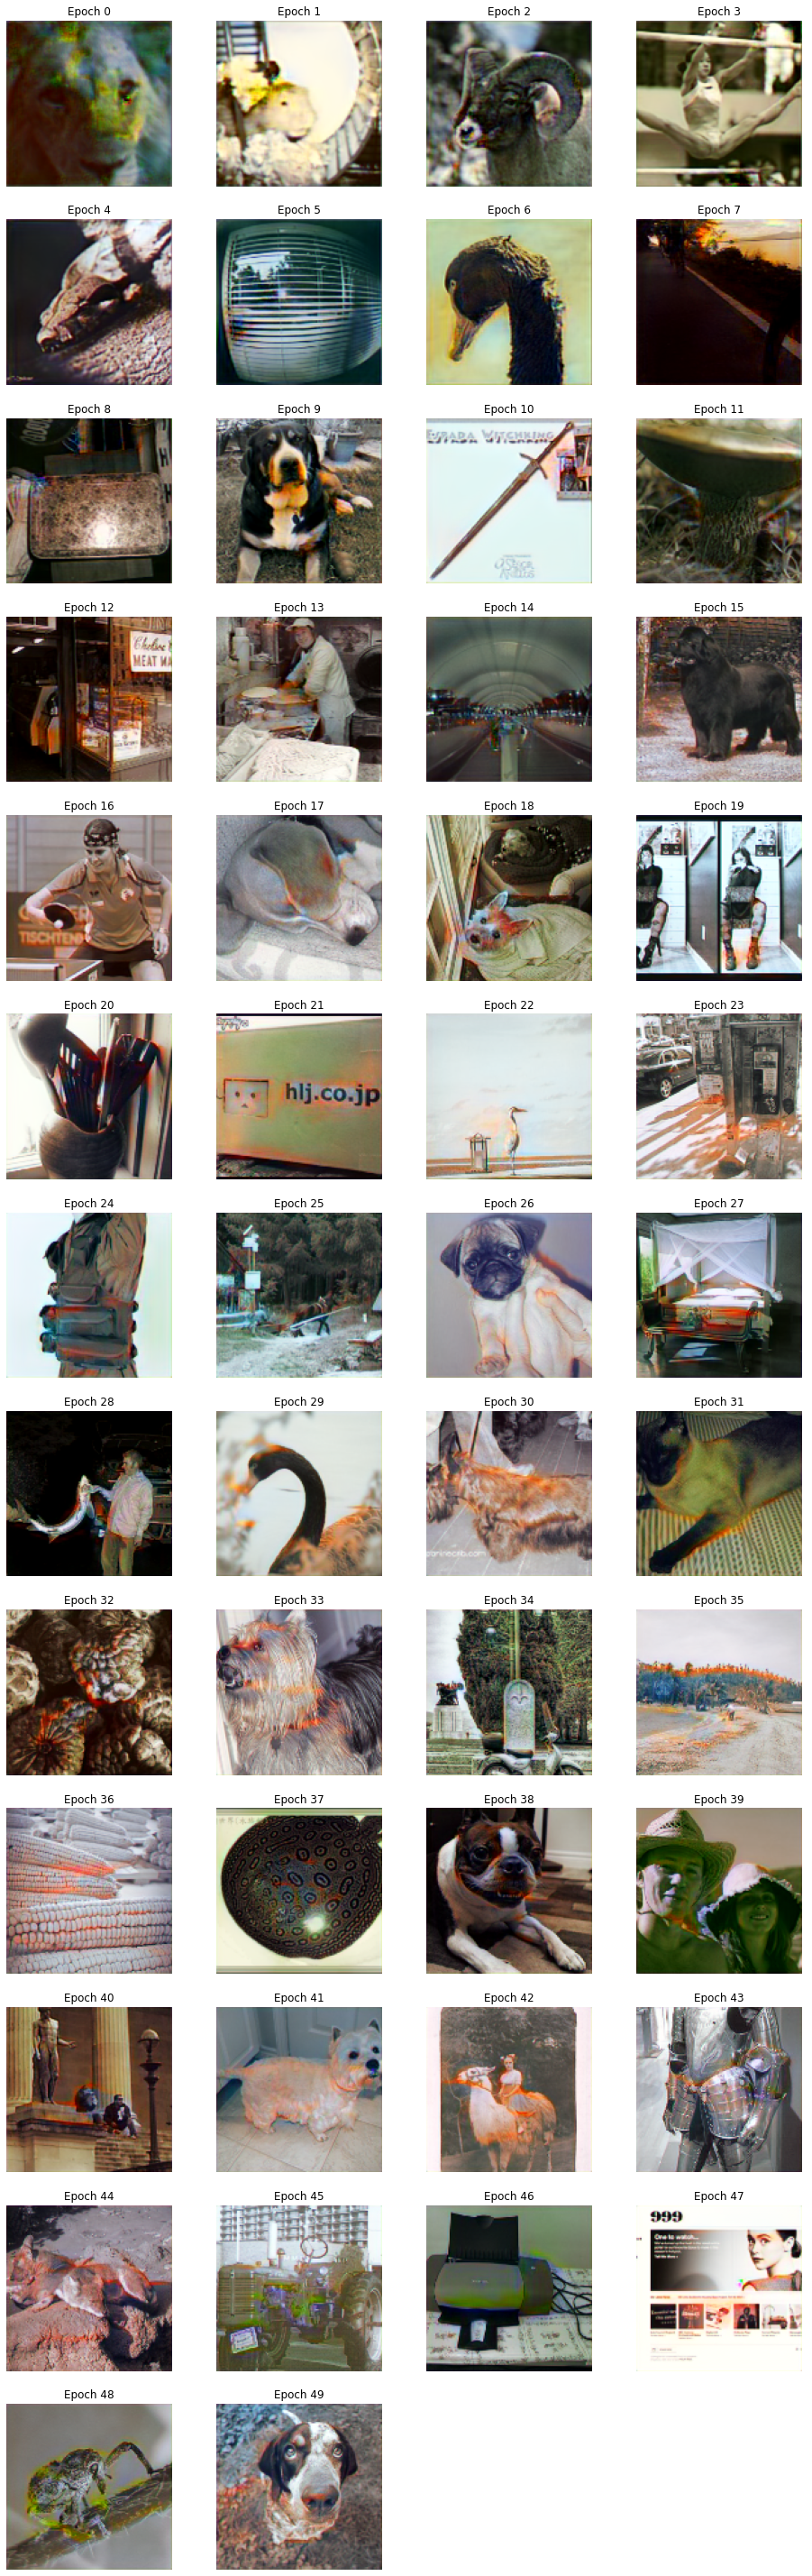

Better model found at epoch 0 with val_loss value: 3.5859880447387695.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 1 with val_loss value: 2.820070505142212.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 2 with val_loss value: 2.7917730808258057.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 3 with val_loss value: 2.371170997619629.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 

Better model found at epoch 19 with val_loss value: 2.3542444705963135.


/mnt/Data/Github/DeOldify/wandbCall.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  #print("aa")
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
/home/mirhady/anaconda3/envs/deoldify/lib/python3.7/site-packages/fastprogress/fastprogress.py:181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.imgs_fig, imgs_axs = plt.subplots(rows, cols, figsize=figsize)
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to 

Better model found at epoch 27 with val_loss value: 2.3356077671051025.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 36 with val_loss value: 2.233278274536133.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 37 with val_loss value: 2.2297301292419434.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Better model found at epoch 41 with val_loss value: 2.0650529861450195.


wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'
wandb: WARNING Unable to log prediction samples.
wandb: WARNING 'Tensor' object has no attribute 'show'


Loaded best saved model from wandb/run-20201206_091819-1mixq5bp/files/bestmodel.pth


In [25]:
learn.fit(50, learn_rate)

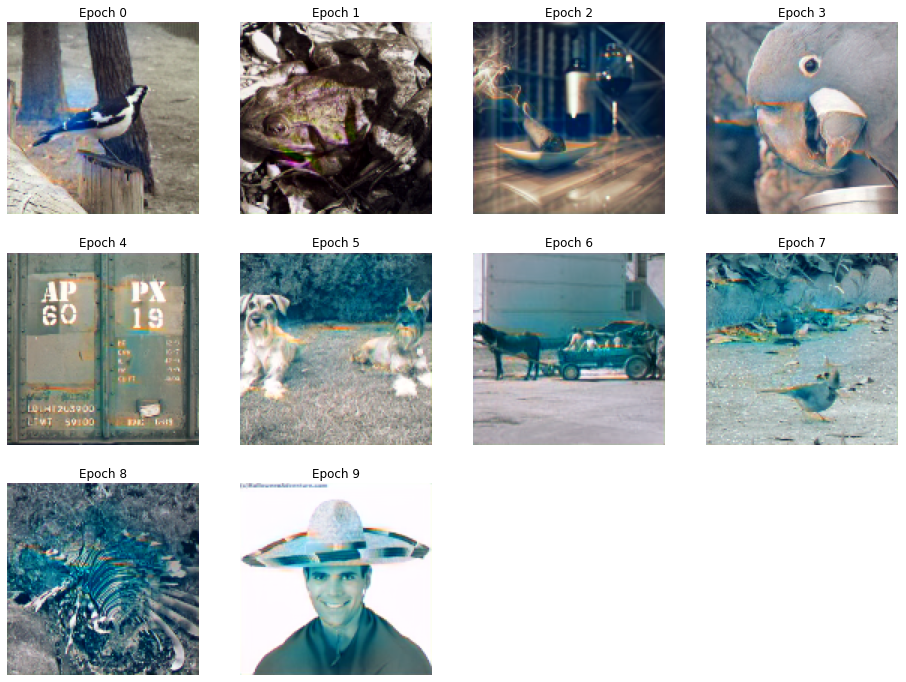

In [78]:
learn.fit(10, learn_rate)

## Save Trained Model

In [79]:
checkpoint_no += 1

In [80]:
gen_new_checkpoint = 'gen_MSGAN_' + str(checkpoint_no)
crit_new_checkpoint = 'crit_MSGAN_' + str(checkpoint_no)

In [81]:
learn_crit.save(crit_new_checkpoint)
learn_gen.save(gen_new_checkpoint)